In [1]:
import iflai
import matplotlib.pyplot as plt
import iflai.ml.features as features
from iflai.ml.feature_selection import AutoFeatureSelection
import numpy as np
import pandas as pd
import glob
import warnings
warnings.filterwarnings("ignore")
from tqdm import tqdm 
from sklearn.model_selection import train_test_split
import h5py
from sklearn.pipeline import Pipeline, FeatureUnion
from sklearn.feature_extraction import DictVectorizer
from iflai.utils import list_of_dict_to_dict
from sklearn.preprocessing import MinMaxScaler 
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV
from xgboost import XGBClassifier
import seaborn as sns

In [2]:
from sklearn.metrics import (plot_confusion_matrix, 
                             matthews_corrcoef, 
                             classification_report,
                             confusion_matrix, 
                             accuracy_score, 
                             balanced_accuracy_score, 
                             cohen_kappa_score, 
                             f1_score,  
                             precision_score, recall_score)
from statsmodels.stats.contingency_tables import mcnemar

def classification_complete_report(estimator, X, y_true, plot = True ): 
    y_pred = estimator.predict(X)
    print(classification_report(y_true, y_pred))
    print(15*"----")
    print("matthews correlation coeff: %.4f" % (matthews_corrcoef(y_true, y_pred)) )
    print("Cohen Kappa score: %.4f" % (cohen_kappa_score(y_true, y_pred)) )
    print("Accuracy: %.4f & balanced Accuracy: %.4f" % (accuracy_score(y_true, y_pred), balanced_accuracy_score(y_true, y_pred)) )
    print("macro F1 score: %.4f & micro F1 score: %.4f" % (f1_score(y_true, y_pred, average = "macro"), f1_score(y_true, y_pred, average = "micro")) )
    print("macro Precision score: %.4f & micro Precision score: %.4f" % (precision_score(y_true, y_pred, average = "macro"), precision_score(y_true, y_pred, average = "micro")) )
    print("macro Recall score: %.4f & micro Recall score: %.4f" % (recall_score(y_true, y_pred, average = "macro"), recall_score(y_true, y_pred, average = "micro")) )
    print(15*"----")
    
    if plot:
        plot_confusion_matrix(estimator, X, y_true,cmap = "Greys", xticks_rotation='vertical')
    

In [3]:
metadata = pd.DataFrame(columns=["file", "set", "label"])
metadata["file"] = glob.glob("/pstore/data/DS4/Cell_Cycle_Reconstruction/Donor/condition/*.h5")
metadata["set"] = "train"

In [4]:
sample_image = h5py.File(metadata["file"].iloc[0],"r").get("image")[()]
sample_mask = h5py.File(metadata["file"].iloc[0],"r").get("mask")[()]

In [5]:
combined_features = FeatureUnion([
    ("GLCMFeatures", features.GLCMFeatures()), 
                                  ("MaskBasedFeatures", features.MaskBasedFeatures()) ,
                                  ("GradientRMS", features.GradientRMS()) ,
                                  ("BackgroundMean", features.BackgroundMean()) ,
                                  ("CellShape", features.CellShape()),
                                  ("HistogramFeatures", features.HistogramFeatures()),
                                  ("Collocalization", features.Collocalization()),
                                  ("CenterOfCellsDistances", features.CenterOfCellsDistances()),
                                     ],
                                n_jobs = -1)

combined_features.fit([None,None])
my_list = combined_features.transform([sample_image,sample_mask]) 
df_features = pd.DataFrame(index = metadata.index, columns=list_of_dict_to_dict(my_list).keys() )

In [6]:
for i in tqdm(range(metadata.shape[0])):
    h5_file =  h5py.File(metadata["file"].iloc[i],"r")
    image = h5_file.get("image")[()]
    mask = h5_file.get("mask")[()]
    label = h5_file.get("label")[()]
    h5_file.close()
    features_ = combined_features.transform([image,mask])
    features_ = list_of_dict_to_dict(features_)
    df_features.loc[i,:] = features_
    metadata.loc[i,"label"] = label

100%|██████████| 1350/1350 [00:29<00:00, 45.31it/s]


In [7]:
df_features = df_features.fillna(0.)
df_features = df_features.loc[:, df_features.std() > .0]

In [8]:
df_features

,contrast_Ch1,dissimilarity_Ch1,homogeneity_Ch1,ASM_Ch1,energy_Ch1,correlation_Ch1,contrast_Ch2,dissimilarity_Ch2,homogeneity_Ch2,ASM_Ch2,...,correlation_distance_R3_Ch3_R2_Ch2,sqeuclidean_distance_R3_Ch3_R2_Ch2,manders_overlap_coefficient_R3_Ch3_R2_Ch2,intensity_correlation_quotient_R3_Ch3_R2_Ch2,cell_distance_Ch1_Ch2,weighted_cell_distance_Ch1_Ch2,cell_distance_Ch1_Ch3,weighted_cell_distance_Ch1_Ch3,cell_distance_Ch2_Ch3,weighted_cell_distance_Ch2_Ch3
0,2508.014406,23.725782,0.172845,0.007012,0.083737,0.079356,396.870591,11.283408,0.410837,0.156212,...,0.0,2631503.0,0.0,-0.5,-1.0,-1.0,0.0,6.913487,-1.0,-1.0
1,2352.353204,22.666667,0.213551,0.012131,0.110139,0.130881,220.659463,5.850720,0.549875,0.271762,...,0.0,1149108.0,0.0,-0.5,-1.0,-1.0,0.0,2.754732,-1.0,-1.0
2,1996.842524,19.486339,0.219558,0.007556,0.086927,-0.061860,193.363388,6.145802,0.550331,0.263010,...,0.0,1253814.0,0.0,-0.5,-1.0,-1.0,0.0,1.412766,-1.0,-1.0
3,2265.791356,21.104322,0.233151,0.013363,0.115598,0.033010,300.702931,6.484352,0.530199,0.239412,...,0.0,2073531.0,0.0,-0.5,-1.0,-1.0,0.0,3.202682,-1.0,-1.0
4,636.848485,11.372081,0.370706,0.036037,0.189834,-0.016321,322.330353,6.730253,0.661102,0.399402,...,0.0,400588.0,0.0,-0.5,-1.0,-1.0,0.0,2.949686,-1.0,-1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1345,2219.287134,19.010432,0.280190,0.013482,0.116112,0.087848,614.914555,12.829111,0.539845,0.260524,...,0.0,875181.0,0.0,-0.5,-1.0,-1.0,0.0,5.063360,-1.0,-1.0
1346,2192.392449,19.972678,0.276334,0.015945,0.126272,0.030834,378.842524,8.294585,0.563572,0.283645,...,0.0,1373109.0,0.0,-0.5,-1.0,-1.0,0.0,1.660476,-1.0,-1.0
1347,3177.945852,27.763537,0.152159,0.007746,0.088014,0.110017,365.229757,9.033035,0.441154,0.180583,...,0.0,2476437.0,0.0,-0.5,-1.0,-1.0,0.0,3.829149,-1.0,-1.0
1348,964.538003,12.778937,0.395651,0.045895,0.214231,0.034089,149.826130,3.747144,0.735347,0.506214,...,0.0,425188.0,0.0,-0.5,-1.0,-1.0,0.0,3.322111,-1.0,-1.0


In [9]:
index_train , index_test = train_test_split(metadata.index, stratify = metadata["label"])

In [22]:
pipeline = Pipeline(steps=[('MinMaxScaler', MinMaxScaler()), 
                           ('AutoFeatureSelection', AutoFeatureSelection(top_k = 64)),
                           ('XGBClassifier', XGBClassifier(n_jobs = -1, eval_metric='logloss')) 
                          ],  verbose=True)
pipeline.fit(df_features.loc[index_train,:],  metadata.loc[index_train, "label"])

[Pipeline] ...... (step 1 of 3) Processing MinMaxScaler, total=   0.0s
Calculating mutual info
Calculating SVC
Calculating random forest
Calculating l1 logistic regression
Calculating l2 logistic
Calculating xgb
From 241 initial features Selected (correlated): 110
From 241 initial features Selected (uncorrelated): 64
[Pipeline]  (step 2 of 3) Processing AutoFeatureSelection, total=  57.8s
[Pipeline] ..... (step 3 of 3) Processing XGBClassifier, total=   0.9s


Pipeline(steps=[('MinMaxScaler', MinMaxScaler()),
                ('AutoFeatureSelection', AutoFeatureSelection(top_k=64)),
                ('XGBClassifier',
                 XGBClassifier(base_score=0.5, booster='gbtree',
                               colsample_bylevel=1, colsample_bynode=1,
                               colsample_bytree=1, eval_metric='logloss',
                               gamma=0, gpu_id=-1, importance_type='gain',
                               interaction_constraints='',
                               learning_rate=0.300000012, max_delta_step=0,
                               max_depth=6, min_child_weight=1, missing=nan,
                               monotone_constraints='()', n_estimators=100,
                               n_jobs=-1, num_parallel_tree=1,
                               objective='multi:softprob', random_state=0,
                               reg_alpha=0, reg_lambda=1, scale_pos_weight=None,
                               subsample=1, tree_

In [23]:
selected_features = pipeline.steps[1][1].selected_features
selected_feature_names = df_features.columns[selected_features]

              precision    recall  f1-score   support

    Anaphase       0.00      0.00      0.00         4
          G1       0.99      0.97      0.98       159
   Metaphase       0.50      0.06      0.11        17
    Prophase       0.87      0.98      0.92       151
   Telophase       0.78      1.00      0.88         7

    accuracy                           0.92       338
   macro avg       0.63      0.60      0.58       338
weighted avg       0.89      0.92      0.90       338

------------------------------------------------------------
matthews correlation coeff: 0.8612
Cohen Kappa score: 0.8563
Accuracy: 0.9201 & balanced Accuracy: 0.6028
macro F1 score: 0.5767 & micro F1 score: 0.9201
macro Precision score: 0.6271 & micro Precision score: 0.9201
macro Recall score: 0.6028 & micro Recall score: 0.9201
------------------------------------------------------------


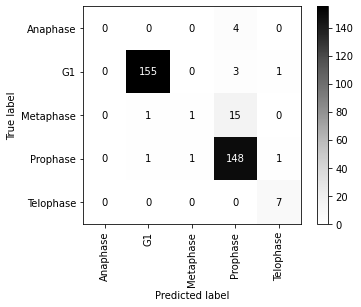

In [24]:
classification_complete_report(pipeline, 
                               df_features.loc[index_test,:], 
                               metadata.loc[index_test, "label"])

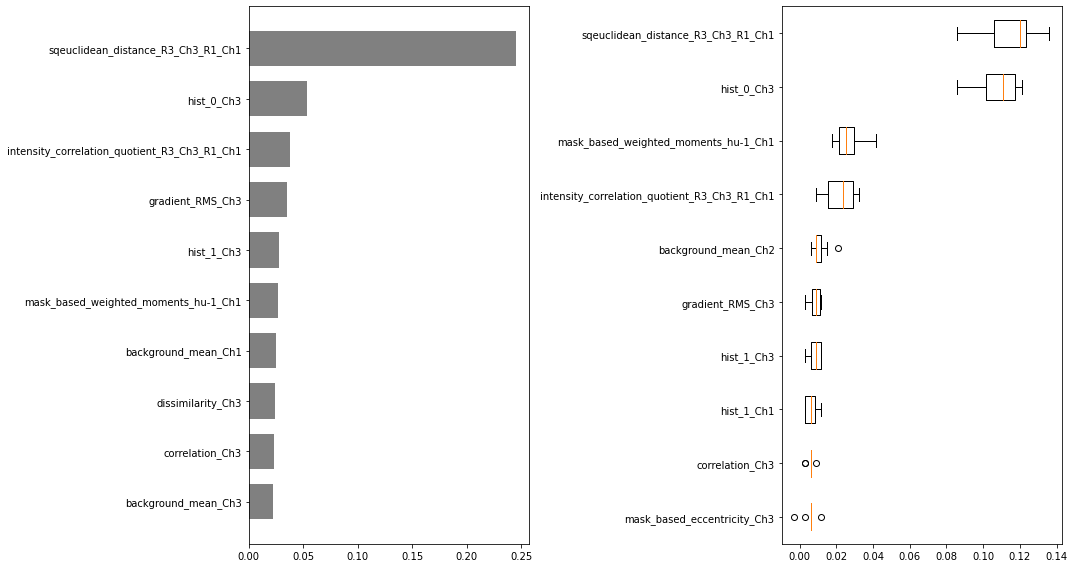

In [25]:

from sklearn.inspection import permutation_importance




fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 8))

tree_importance_sorted_idx = np.argsort(pipeline.steps[2][1].feature_importances_)[-10:]

tree_indices = np.arange(0, 10) + 0.5

ax1.barh(tree_indices, 
         pipeline.steps[2][1].feature_importances_[tree_importance_sorted_idx], 
         height=0.7, color  = "grey")
ax1.set_yticklabels(df_features.columns[selected_features].values[tree_importance_sorted_idx])
ax1.set_yticks(tree_indices)


result = permutation_importance(pipeline, 
                                df_features.loc[index_test,:],  
                                metadata.loc[index_test, "label"], n_repeats=10,
                                random_state=42)
perm_sorted_idx = result.importances_mean.argsort()[-10:]
ax2.boxplot(result.importances[perm_sorted_idx].T, 
            vert=False,
            labels=df_features.columns.values[perm_sorted_idx])

fig.tight_layout()

In [26]:

channel_importance_xgb = {"Ch1" : 0., "Ch2" : 0., "Ch3": 0.}

for i,f in enumerate(selected_feature_names):
    value = pipeline.steps[2][1].feature_importances_[i]
    if "Ch1" in f:
        channel_importance_xgb["Ch1"] = channel_importance_xgb["Ch1"] + value
    elif "Ch2" in f:
        channel_importance_xgb["Ch2"] = channel_importance_xgb["Ch2"] + value
    elif "Ch3" in f:
        channel_importance_xgb["Ch3"] = channel_importance_xgb["Ch3"] + value


channel_importance_permutation = {"Ch1" : 0., "Ch2" : 0., "Ch3": 0.}

for i,f in enumerate(df_features.columns):
    value = result['importances_mean'][i]
    if "Ch1" in f:
        channel_importance_permutation["Ch1"] = channel_importance_permutation["Ch1"] + value
    elif "Ch2" in f:
        channel_importance_permutation["Ch2"] = channel_importance_permutation["Ch2"] + value
    elif "Ch3" in f:
        channel_importance_permutation["Ch3"] = channel_importance_permutation["Ch3"] + value


Text(0.5, 1.0, 'Channel importance')

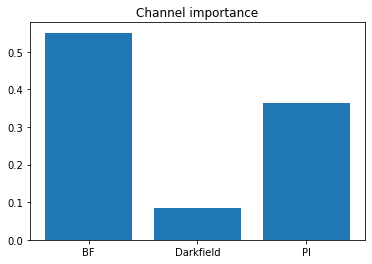

In [27]:
plt.bar(["BF", "Darkfield", "PI"], channel_importance_xgb.values())
plt.title("Channel importance")

Text(0.5, 1.0, 'Channel importance')

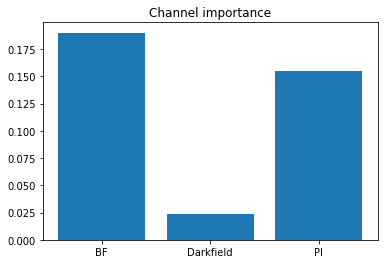

In [28]:
plt.bar(["BF", "Darkfield", "PI"], channel_importance_permutation.values())
plt.title("Channel importance")

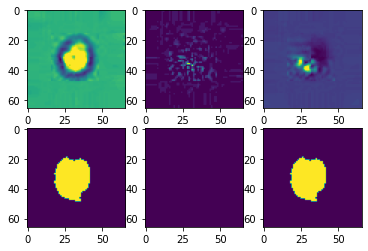

In [29]:
fix, ax = plt.subplots(2,3)

ax[0,0].imshow(image[:,:,0])
ax[0,1].imshow(image[:,:,1])
ax[0,2].imshow(image[:,:,2])

ax[1,0].imshow(mask[:,:,0])
ax[1,1].imshow(mask[:,:,1])
ax[1,2].imshow(mask[:,:,2])